In [1]:
from graphviz import Digraph

def trace(root):
    #Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR == Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #For any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % ( n.label, n.data, n.grad), shape='record')
        if n._op:
            #If this value is a result of some operation, then create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #Connect n1 to the node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [2]:
import math

In [3]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None #Its an empty function by default. This is what will do that gradient calculation at each of the operations.
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad

        out._backward = backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
        out._backward = backward
        return out

    def __rmul__(self, other):   #other * self
        return self * other

    def __truediv__(self, other):  #self/other
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):  #self - other
        return self + (-other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f"**{other}")

        def backward():
          self.grad += (other * (self.data ** (other - 1))) * out.grad

        out._backward = backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def backward():
          self.grad += 1 - (t**2) * out.grad

        out._backward = backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')   #We merged t and out, into just out

        def backward():
            self.grad += out.data * out.grad

        out._backward = backward
        return out

    def backward(self):

      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)

      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
        node._backward()

---------------

In [5]:
import random

In [8]:
class Neuron:
	def __init__(self, nin):
		self.w = [ Value(random.uniform(-1,1)) for _ in range(nin) ]
		self.b = Value(random.uniform(-1,1))

	def __call__(self, x):
		# (w*x)+b
		act = sum( (wi*xi for wi,xi in zip(self.w, x)), self.b )
		out = act.tanh()
		return out

class Layer:
	def __init__(self, nin, nout):
		self.neurons = [Neuron(nin) for _ in range(nout)]

	def __call__(self, x):
		outs = [n(x) for n in self.neurons]
		return outs

class MLP:
	def __init__(self, nin, nouts):
		sz = [nin] + nouts
		self.layers = [ Layer(sz[i], sz[i+1]) for i in range(len(nouts)) ]

	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x

In [9]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

[Value(data=0.6731685486278488)]

Now in the final output, we see it in the form of a list right. \
\
So just for making this look better, we are adding this one line in the return statement of the layer method where if it is just one value left i.e. if it is the last value, then just return that value directly instead of putting it inside a list.

In [10]:
class Neuron:
	def __init__(self, nin):
		self.w = [ Value(random.uniform(-1,1)) for _ in range(nin) ]
		self.b = Value(random.uniform(-1,1))

	def __call__(self, x):
		# (w*x)+b
		act = sum( (wi*xi for wi,xi in zip(self.w, x)), self.b )
		out = act.tanh()
		return out

class Layer:
	def __init__(self, nin, nout):
		self.neurons = [Neuron(nin) for _ in range(nout)]

	def __call__(self, x):
		outs = [n(x) for n in self.neurons]
		return outs[0] if len(outs)==1 else outs  #The New added line for making the output better

class MLP:
	def __init__(self, nin, nouts):
		sz = [nin] + nouts
		self.layers = [ Layer(sz[i], sz[i+1]) for i in range(len(nouts)) ]

	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x

In [11]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.597277746687069)

Like that!\
\
Now finally, lets make the graph of this

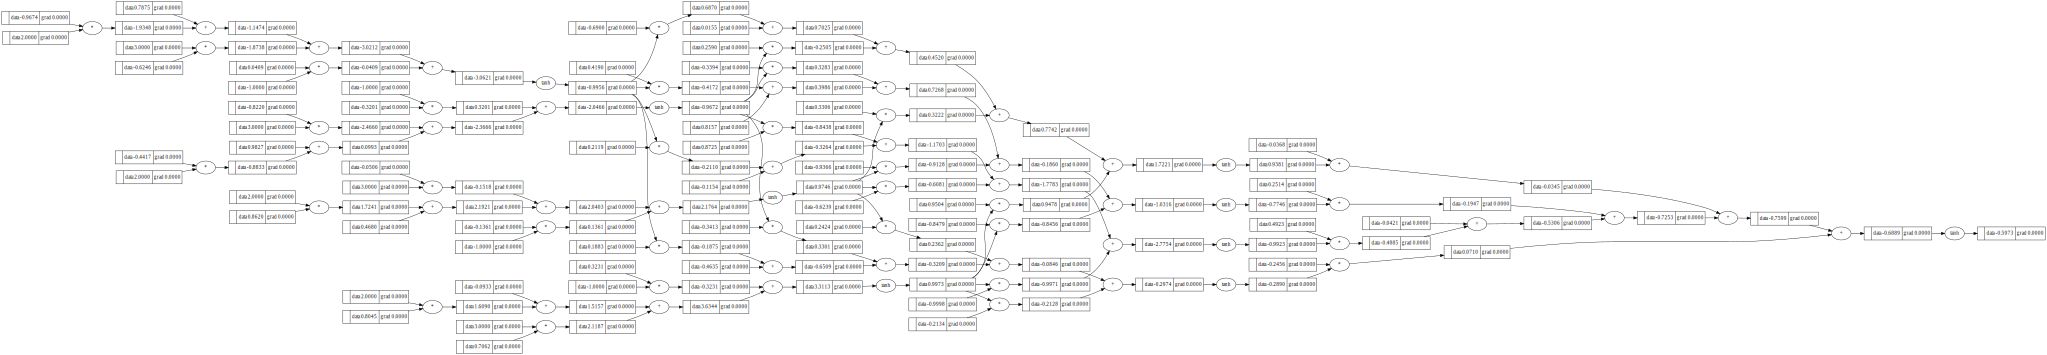

In [12]:
draw_dot(n(x))

**THAT'S AN ENTIRE MLP THAT WE'VE DEFINED NOW!**